# Recap from Analysis

**`Pclass`**
* `Pclass` highly contributes to survival, with more 1st class passengers surviving over 3rd class passengers

**`Sex`**:
* `Sex` highly contributes to survival, with more female passengers surviving over male passengers, even when qualified with `Pclass`

**`Embarked`**
* Passengers with an `Embarked` value of C tend to survive more but that may be because there is just a larger number of 1st class passengers who embarked from there. 
* When grouped with `Embarked`, `Sex` and `Pclass` correlations to survival hold
* More 1st class passengers embarked from S than C, and more 1st class passengers embarked from C than Q. In general, more passengers embarked from S than C, and C than Q. Queenstown is made up mostly of 3rd class passengers, and Cherbourg has more 1st class passengers than 3rd or 2nd class passengers.
* No definite relationship between `Embarked` and `Survival` except what can be explained by `Pclass`
* **`Embarked` may be a removable feature, but can still be used for feature engineering**

**`Ticket`**
* `Ticket` contains some mistakes in spelling (STON vs SOTON, PARIS vs Paris)
* Passengers who rode together have the same ticket number, allowing us to group into travel groups/families
* Passengers with the same ticket value also have the same `Fare` (usually), similar `cabins`, and the same `Embarked` value

**`Name`**
* `Name` consists of several titles. Each passenger has some kind of title. 
* The title can be used to impute age values.

**`Fare`**
* `Fare` is correlated slightly with `Embarked`, but only because there is a higher percentage of 1st class passengers in `Embarked == C`. In `Embarked == S`, the mean fare is slightly lower than `Embarked == C`.
* There is an outlier `Fare`, a passenger embarking from Cherbourg, Thomas Cardeza.

**`Cabin`**
* `Cabin == B, Cabin == C` has the highest survival rates. These are also the most expensive cabins, and contain the majority of 1st class passengers.
* `Cabin` should consist of only the deck values, not the number.
* There are 687 null values, so we might have to remove this column so we don't introduce too much noise.

**`Age`**
* `Age` is missing 177 values
* `Age` should be imputed since there is a spike in survival in the lower age range.
* We might be able to consider using feature bands instead of definite values to reduce granularity.

**`Sibsp` and `Parch`**
* There is no significant relationship between `Parch` and `Survived`, and `Sibsp` and `Survived`, but there is a spike in survival when `Sibsp` is greater than 2. A `Sibsp` greater than 2 means that you are in the younger range, since you can only have 1 spouse.
* For `Parch`, the relationship is less clear

---
Sections to Consider:
* Cleaning
* Transformation
* Imputing
* Feature Engineering
* Check
* Train
* Test

In [1]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, scale, OneHotEncoder, LabelEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.drop('PassengerId', axis=1, inplace=True)

I'll be creating copies of the training set as I make changes, rather than making inplace changes. I'll need a way to merge these copied dataframes.

# Cleaning

This section will be for removing rows/columns that have missing data and determining whether all data is sensible (e.g. no outliers, or inconsistent data). 

**What do we know?**
* `Name` all has titles, which is our main concern. 
* `Sex` only has 2 possible values: Male or Female
* `Fare` has a few values that are 0: these can be grouped into `Fare` feature bands.
* `Embarked` has 2 missing rows
* `Cabin` has many missing rows: might remove, but we know that cabin decks B and C have the highest chance of survival. This might also be because they are predominantly first class though, so trying to impute misisng values may still just produce unnecessary noise.
* `Parch` and `SibSp` both are reasonable with low values.
* `Pclass` has 3 unique values: 1, 2, 3
* `Ticket` is reasonable
* `Age` should be imputed. It's missing just under 200 rows, but children definitely have a higher chance of survival.

## `Embarked` Row Removal

In [3]:
train.dropna(axis=0, subset=['Embarked'], inplace=True)
train = train.reset_index(drop=True)
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
884,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
885,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
886,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
887,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Name      889 non-null    object 
 3   Sex       889 non-null    object 
 4   Age       712 non-null    float64
 5   SibSp     889 non-null    int64  
 6   Parch     889 non-null    int64  
 7   Ticket    889 non-null    object 
 8   Fare      889 non-null    float64
 9   Cabin     202 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.5+ KB


Now there are missing values only in `Age` and `Cabin`.

## `Cabin` Column Removal

`Cabin` has many missing values, and imputing or filling in values may just introduce noise. Remove the column.

In [5]:
train.drop('Cabin', axis=1, inplace=True)
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...
884,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
885,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
886,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S
887,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Name      889 non-null    object 
 3   Sex       889 non-null    object 
 4   Age       712 non-null    float64
 5   SibSp     889 non-null    int64  
 6   Parch     889 non-null    int64  
 7   Ticket    889 non-null    object 
 8   Fare      889 non-null    float64
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.6+ KB


# Transformation/Encoding

## `Name` to `Title`

We should use one-hot-encoding and assign `Title` columns

In [7]:
title_encoded_df = train.copy()
titles_series = title_encoded_df['Name'].str.extract(r'(\w*)\..*')
one_hot_encoded_titles = pd.get_dummies(titles_series, prefix='Title', prefix_sep='')
display(train)
title_encoded_df = title_encoded_df.assign(**one_hot_encoded_titles.to_dict('list'))
title_encoded_df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...
884,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
885,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
886,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S
887,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,...,TitleMajor,TitleMaster,TitleMiss,TitleMlle,TitleMme,TitleMr,TitleMrs,TitleMs,TitleRev,TitleSir
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,...,0,0,0,0,0,1,0,0,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,...,0,0,0,0,0,0,1,0,0,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,...,0,0,1,0,0,0,0,0,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,...,0,0,0,0,0,0,1,0,0,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,...,0,0,0,0,0,0,0,0,1,0
885,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,...,0,0,1,0,0,0,0,0,0,0
886,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S,...,0,0,1,0,0,0,0,0,0,0
887,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,...,0,0,0,0,0,1,0,0,0,0


In [8]:
train = title_encoded_df

Encoding `Title` is done to help the age imputation process. I don't intend to keep these columns because:
1. Titles don't have an impact on survival rate and are redundant.
2. There is no guarantee that all the titles in the training set will be present later.
3. There are some levels that have only a few observations. 

For these reasons, it may be difficult to accurately model the relationship between title and survival.

## `Sex` to `IsMale`

In [9]:
sex_encoded_df = train.copy()
sex_encoded_df['Sex'] = sex_encoded_df['Sex'].astype('category').cat.codes
sex_encoded_df = sex_encoded_df.rename(columns={'Sex': 'IsMale'})

In [10]:
train = sex_encoded_df

## `Embarked` One Hot Encoding

In [11]:
embarked_encoded_df = train.copy()
one_hot_encoded_embarked = pd.get_dummies(embarked_encoded_df['Embarked'], prefix='Embarked', prefix_sep='')
embarked_encoded_df.drop('Embarked', axis=1, inplace=True)
embarked_encoded_df = embarked_encoded_df.assign(**one_hot_encoded_embarked.to_dict('list'))
embarked_encoded_df

,Survived,Pclass,Name,IsMale,Age,SibSp,Parch,Ticket,Fare,TitleCapt,...,TitleMlle,TitleMme,TitleMr,TitleMrs,TitleMs,TitleRev,TitleSir,EmbarkedC,EmbarkedQ,EmbarkedS
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,0,...,0,0,0,1,0,0,0,1,0,0
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,0,...,0,0,0,1,0,0,0,0,0,1
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.0000,0,...,0,0,0,0,0,1,0,0,0,1
885,1,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,112053,30.0000,0,...,0,0,0,0,0,0,0,0,0,1
886,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,NaN,1,2,W./C. 6607,23.4500,0,...,0,0,0,0,0,0,0,0,0,1
887,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,30.0000,0,...,0,0,1,0,0,0,0,1,0,0


In [12]:
train = embarked_encoded_df

# Imputing 

## Age Imputing

In [13]:
cols_to_remove = ['Ticket', 'Survived', 'Name']
imp_age_df = train.drop(cols_to_remove, axis=1)
imp_age_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         889 non-null    int64  
 1   IsMale         889 non-null    int8   
 2   Age            712 non-null    float64
 3   SibSp          889 non-null    int64  
 4   Parch          889 non-null    int64  
 5   Fare           889 non-null    float64
 6   TitleCapt      889 non-null    int64  
 7   TitleCol       889 non-null    int64  
 8   TitleCountess  889 non-null    int64  
 9   TitleDon       889 non-null    int64  
 10  TitleDr        889 non-null    int64  
 11  TitleJonkheer  889 non-null    int64  
 12  TitleLady      889 non-null    int64  
 13  TitleMajor     889 non-null    int64  
 14  TitleMaster    889 non-null    int64  
 15  TitleMiss      889 non-null    int64  
 16  TitleMlle      889 non-null    int64  
 17  TitleMme       889 non-null    int64  
 18  TitleMr   

In [14]:
imputer = IterativeImputer(random_state=0)

In [15]:
numpy_data = imp_age_df.to_numpy()
imputer.fit(numpy_data)
imp_age_df = pd.DataFrame(imputer.transform(numpy_data), columns=imp_age_df.columns)
imp_age_df

,Pclass,IsMale,Age,SibSp,Parch,Fare,TitleCapt,TitleCol,TitleCountess,TitleDon,...,TitleMlle,TitleMme,TitleMr,TitleMrs,TitleMs,TitleRev,TitleSir,EmbarkedC,EmbarkedQ,EmbarkedS
0,3.0,1.0,22.00000,1.0,0.0,7.2500,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,38.00000,1.0,0.0,71.2833,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3.0,0.0,26.00000,0.0,0.0,7.9250,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,35.00000,1.0,0.0,53.1000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3.0,1.0,35.00000,0.0,0.0,8.0500,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,2.0,1.0,27.00000,0.0,0.0,13.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
885,1.0,0.0,19.00000,0.0,0.0,30.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
886,3.0,0.0,15.38935,1.0,2.0,23.4500,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
887,1.0,1.0,26.00000,0.0,0.0,30.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


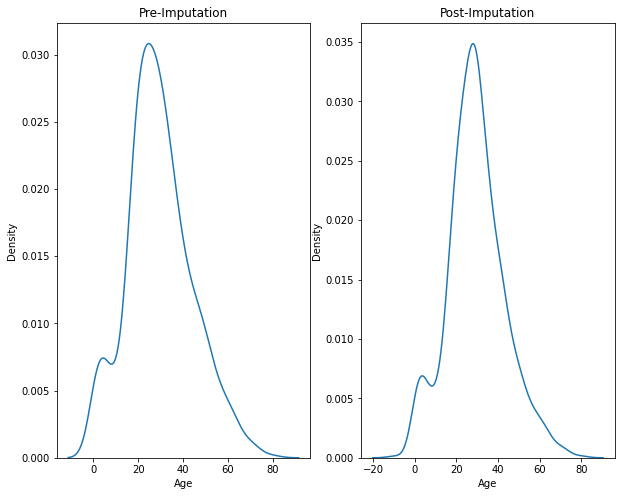

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
ax1.set_title('Pre-Imputation')
ax2.set_title('Post-Imputation')
sns.kdeplot(data=train, x='Age', ax=ax1)
sns.kdeplot(data=imp_age_df, x='Age', ax=ax2)
plt.show()

In [17]:
train['Age'] = imp_age_df['Age']

## Datatype cleaning for categorical columns

Let's make the data types specific.

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       889 non-null    int64  
 1   Pclass         889 non-null    int64  
 2   Name           889 non-null    object 
 3   IsMale         889 non-null    int8   
 4   Age            889 non-null    float64
 5   SibSp          889 non-null    int64  
 6   Parch          889 non-null    int64  
 7   Ticket         889 non-null    object 
 8   Fare           889 non-null    float64
 9   TitleCapt      889 non-null    int64  
 10  TitleCol       889 non-null    int64  
 11  TitleCountess  889 non-null    int64  
 12  TitleDon       889 non-null    int64  
 13  TitleDr        889 non-null    int64  
 14  TitleJonkheer  889 non-null    int64  
 15  TitleLady      889 non-null    int64  
 16  TitleMajor     889 non-null    int64  
 17  TitleMaster    889 non-null    int64  
 18  TitleMiss 

In [19]:
hot_encoded_columns = lambda prefix: [col for col in train.columns if prefix in col]
title_columns = hot_encoded_columns('Title')
embarked_columns = hot_encoded_columns('Embarked')
cat_columns = ['Pclass', 'Survived', 'IsMale'] + title_columns + embarked_columns
train[cat_columns] = train[cat_columns].astype('int8')

# Feature Engineering

We will consider the following features:
* Group Size

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       889 non-null    int8   
 1   Pclass         889 non-null    int8   
 2   Name           889 non-null    object 
 3   IsMale         889 non-null    int8   
 4   Age            889 non-null    float64
 5   SibSp          889 non-null    int64  
 6   Parch          889 non-null    int64  
 7   Ticket         889 non-null    object 
 8   Fare           889 non-null    float64
 9   TitleCapt      889 non-null    int8   
 10  TitleCol       889 non-null    int8   
 11  TitleCountess  889 non-null    int8   
 12  TitleDon       889 non-null    int8   
 13  TitleDr        889 non-null    int8   
 14  TitleJonkheer  889 non-null    int8   
 15  TitleLady      889 non-null    int8   
 16  TitleMajor     889 non-null    int8   
 17  TitleMaster    889 non-null    int8   
 18  TitleMiss 

In [21]:
train

,Survived,Pclass,Name,IsMale,Age,SibSp,Parch,Ticket,Fare,TitleCapt,...,TitleMlle,TitleMme,TitleMr,TitleMrs,TitleMs,TitleRev,TitleSir,EmbarkedC,EmbarkedQ,EmbarkedS
0,0,3,"Braund, Mr. Owen Harris",1,22.00000,1,0,A/5 21171,7.2500,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.00000,1,0,PC 17599,71.2833,0,...,0,0,0,1,0,0,0,1,0,0
2,1,3,"Heikkinen, Miss. Laina",0,26.00000,0,0,STON/O2. 3101282,7.9250,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.00000,1,0,113803,53.1000,0,...,0,0,0,1,0,0,0,0,0,1
4,0,3,"Allen, Mr. William Henry",1,35.00000,0,0,373450,8.0500,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,0,2,"Montvila, Rev. Juozas",1,27.00000,0,0,211536,13.0000,0,...,0,0,0,0,0,1,0,0,0,1
885,1,1,"Graham, Miss. Margaret Edith",0,19.00000,0,0,112053,30.0000,0,...,0,0,0,0,0,0,0,0,0,1
886,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,15.38935,1,2,W./C. 6607,23.4500,0,...,0,0,0,0,0,0,0,0,0,1
887,1,1,"Behr, Mr. Karl Howell",1,26.00000,0,0,111369,30.0000,0,...,0,0,1,0,0,0,0,1,0,0


## Family Size

Here, we'll look at the sum of Parch and SibSp and add in any additional travelers that are on the same ticket.

Let's first make sure that `Parch` and `SibSp` for every person is no greater than the number of people on their ticket.

In [22]:
remove_columns = [col for col in train.columns if re.search(r'Title|Embarked', col)]
ticket_lookup = train.groupby('Ticket').size()
ticket_lookup = ticket_lookup.reset_index().rename({0: 'GroupSize'}, axis=1)
ticket_group_sizes = pd.merge(train.drop(remove_columns, axis=1), ticket_lookup, on='Ticket')

# parch + sibsp can't be greater than or equal to group size because parch + sibsp + 1 (for passenger) <= group size
split_families = ticket_group_sizes[ticket_group_sizes['Parch'] + ticket_group_sizes['SibSp'] >= ticket_group_sizes['GroupSize']]

# remove title columns and Embarked columns just to shrink the dataframe for viewing purposes
split_families

,Survived,Pclass,Name,IsMale,Age,SibSp,Parch,Ticket,Fare,GroupSize
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1
8,0,3,"Palsson, Master. Gosta Leonard",1,2.0,3,1,349909,21.0750,4
9,0,3,"Palsson, Miss. Torborg Danira",0,8.0,3,1,349909,21.0750,4
10,0,3,"Palsson, Miss. Stina Viola",0,3.0,3,1,349909,21.0750,4
...,...,...,...,...,...,...,...,...,...,...
863,1,1,"Lines, Miss. Mary Conover",0,16.0,0,1,PC 17592,39.4000,1
864,1,3,"Aks, Mrs. Sam (Leah Rosen)",0,18.0,0,1,392091,9.3500,1
867,0,3,"Hansen, Mr. Claus Peter",1,41.0,2,0,350026,14.1083,1
868,0,2,"Giles, Mr. Frederick Edward",1,21.0,1,0,28134,11.5000,1


Let's take an example, Mr. Owen Harris Braund. The number of people on his ticket is 1, however, Braund had a sibling on board with him, so the ticket should have two people under it. 

In [23]:
def get_family(lastname: str) -> pd.DataFrame:
    last_name_present_series = train['Name'].str.extract(f'({lastname})', expand=False)
    return train[last_name_present_series.notna()].drop(remove_columns, axis=1)

In [24]:
get_family('Braund')

,Survived,Pclass,Name,IsMale,Age,SibSp,Parch,Ticket,Fare
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500
476,0,3,"Braund, Mr. Lewis Richard",1,29.0,1,0,3460,7.0458


In [25]:
get_family('Palsson')

,Survived,Pclass,Name,IsMale,Age,SibSp,Parch,Ticket,Fare
7,0,3,"Palsson, Master. Gosta Leonard",1,2.0,3,1,349909,21.075
24,0,3,"Palsson, Miss. Torborg Danira",0,8.0,3,1,349909,21.075
373,0,3,"Palsson, Miss. Stina Viola",0,3.0,3,1,349909,21.075
566,0,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",0,29.0,0,4,349909,21.075


Using `Ticket` as a group identifier shows a few problems. Family members may not be on the same ticket; they may be split across several tickets. In addition, the group size calculated may not represent the full group size since we don't have the entire manifest. There may be additional people in the group that aren't recorded in this dataset, as seen with the Palsson family.

Let's focus on what the data tells us explicitly: the size of the family. We can get this by summing `SibSp` and `Parch`. 

In [26]:
family_sizes = train['Parch'] + train['SibSp']
family_sizes

0      1
1      1
2      0
3      1
4      0
      ..
884    0
885    0
886    3
887    0
888    0
Length: 889, dtype: int64

In [27]:
train['FamilySize'] = family_sizes
train

,Survived,Pclass,Name,IsMale,Age,SibSp,Parch,Ticket,Fare,TitleCapt,...,TitleMme,TitleMr,TitleMrs,TitleMs,TitleRev,TitleSir,EmbarkedC,EmbarkedQ,EmbarkedS,FamilySize
0,0,3,"Braund, Mr. Owen Harris",1,22.00000,1,0,A/5 21171,7.2500,0,...,0,1,0,0,0,0,0,0,1,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.00000,1,0,PC 17599,71.2833,0,...,0,0,1,0,0,0,1,0,0,1
2,1,3,"Heikkinen, Miss. Laina",0,26.00000,0,0,STON/O2. 3101282,7.9250,0,...,0,0,0,0,0,0,0,0,1,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.00000,1,0,113803,53.1000,0,...,0,0,1,0,0,0,0,0,1,1
4,0,3,"Allen, Mr. William Henry",1,35.00000,0,0,373450,8.0500,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,0,2,"Montvila, Rev. Juozas",1,27.00000,0,0,211536,13.0000,0,...,0,0,0,0,1,0,0,0,1,0
885,1,1,"Graham, Miss. Margaret Edith",0,19.00000,0,0,112053,30.0000,0,...,0,0,0,0,0,0,0,0,1,0
886,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,15.38935,1,2,W./C. 6607,23.4500,0,...,0,0,0,0,0,0,0,0,1,3
887,1,1,"Behr, Mr. Karl Howell",1,26.00000,0,0,111369,30.0000,0,...,0,1,0,0,0,0,1,0,0,0


In [28]:
train[['FamilySize', 'Survived']].groupby('FamilySize').agg(['mean', 'count'])

Survived      
                mean count
FamilySize                
0           0.300935   535
1           0.552795   161
2           0.578431   102
3           0.724138    29
4           0.200000    15
5           0.136364    22
6           0.333333    12
7           0.000000     6
10          0.000000     7

# Final Check

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       889 non-null    int8   
 1   Pclass         889 non-null    int8   
 2   Name           889 non-null    object 
 3   IsMale         889 non-null    int8   
 4   Age            889 non-null    float64
 5   SibSp          889 non-null    int64  
 6   Parch          889 non-null    int64  
 7   Ticket         889 non-null    object 
 8   Fare           889 non-null    float64
 9   TitleCapt      889 non-null    int8   
 10  TitleCol       889 non-null    int8   
 11  TitleCountess  889 non-null    int8   
 12  TitleDon       889 non-null    int8   
 13  TitleDr        889 non-null    int8   
 14  TitleJonkheer  889 non-null    int8   
 15  TitleLady      889 non-null    int8   
 16  TitleMajor     889 non-null    int8   
 17  TitleMaster    889 non-null    int8   
 18  TitleMiss 

In [30]:
train.drop(['Name', 'Parch', 'SibSp', 'Ticket'], axis=1, inplace=True)

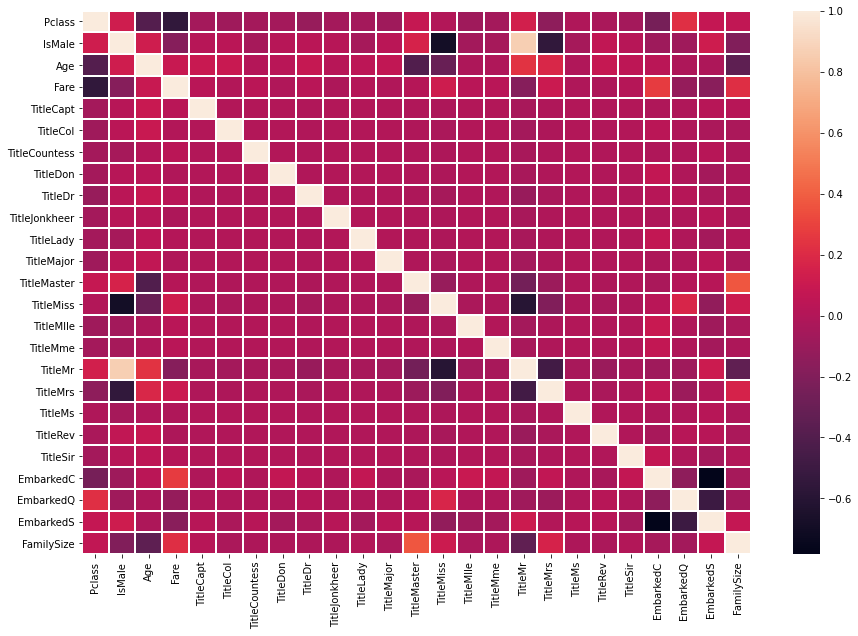

In [139]:
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
sns.heatmap(train.drop('Survived', axis=1).corr(), linewidth=1)
plt.show()

# Training

## Setup

In [32]:
# constants and evaluation parameters
n_splits = 5
random_state = 1
test_size = 0.2
feature_set = lambda t: t.drop('Survived', axis=1)
response_set = lambda t: t['Survived']

In [33]:
# train/test split
raw_train = pd.read_csv('train.csv')
raw_train.dropna(axis=0, subset=['Embarked'], inplace=True)
raw_train = raw_train.reset_index(drop=True)

train_features, test_features, train_response, test_response = train_test_split(
    feature_set(raw_train), response_set(raw_train), test_size=test_size, random_state=random_state)

## Models and Pipelines

In [34]:
# Function Transformers

def sum_columns(X: pd.DataFrame) -> np.array:
    y = sum(X[col] for col in X.columns)
    return np.array(y)[:,np.newaxis]
    
def remove_columns(X: pd.DataFrame) -> np.array:
    return np.ndarray(shape=(len(X),0))

class TitleExtractor(OneHotEncoder):
    TITLE_REGEX = r'(\w*)\..*'
    
    def __init__(self, *, name_column='Name', categories='auto', 
                 drop=None, sparse=False, dtype=np.float64, handle_unknown='error'):
        self.name_column = name_column
        super().__init__(categories=categories, drop=drop, sparse=sparse, 
                         dtype=dtype, handle_unknown=handle_unknown)
    
    def fit(self, X, y=None, **kwargs):
        """
        expects a pandas DataFrame
        
        Parameters
        ----------
        X : pandas DataFrame
        """
        data_series = X[self.name_column]
        super().fit(self.__get_title_series(data_series))
        return self
    
    def transform(self, X):
        """
        expects a pandas DataFrame
        """
        data_series = X[self.name_column]
        return super().transform(self.__get_title_series(data_series))
    
    def __get_title_series(self, data_series):
        """
        expects a pandas Series.
        """
        return data_series.str.extract(TitleExtractor.TITLE_REGEX, expand=True).to_numpy()

In [185]:
# pipeline steps:
# remove PassengerId, Cabin
# Column Transform Name encoded
# Column Transform Sex encoded
# Column Transform Embarked encoded
# imputation
# Standardizing numerical values

encoder = ColumnTransformer([("remove_columns", FunctionTransformer(remove_columns), ['Cabin', 'PassengerId', 'Ticket']),
                             ("name_to_titles", TitleExtractor(handle_unknown='ignore'), ['Name']),
                             ("encode_sex", OrdinalEncoder(), ['Sex']),
                             ("encode_embarked", OneHotEncoder(), ['Embarked']), 
                             ("family_size", FunctionTransformer(sum_columns), ['Parch', 'SibSp'])],
                            remainder='passthrough')
pipeline_steps = [
    # col transform
    ("encode", encoder),
    # impute age
    ("multi_impute", IterativeImputer(random_state=random_state, max_iter=10000, tol=1e-1)), 
    # standardize
    ("standardize_age_fare", ColumnTransformer(
        [("standardize", StandardScaler(), slice(-2, None))], # age and fare end up being the last columns
        remainder='passthrough')),
]

In [186]:
def prepend_pipeline_to_model(steps: list, model_name, model) -> Pipeline:
    return Pipeline(steps + [(model_name, model)])
    
models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GradientBoostedTree": GradientBoostingClassifier(random_state=random_state),
    "BaggedTree": BaggingClassifier(random_state=random_state, oob_score=True),
    "RandomForest": RandomForestClassifier(random_state=random_state, oob_score=True, class_weight='balanced'),
    # 38.38% of collected passengers have class 1 (survived)
    "LogisticRegression": LogisticRegression(max_iter=10000, random_state=random_state, class_weight='balanced'),
    "SVC": SVC(),
}

pipelines = { name: prepend_pipeline_to_model(pipeline_steps, name, model) for name, model in models.items() }

## Cross Validation

In [187]:
# model evaluation
def evaluate_model(train_features, train_response, pipeline: Pipeline, scoring='accuracy'):
    cv = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    score = cross_val_score(pipeline, train_features, train_response, cv=cv, scoring=scoring)
    return score.mean(), score.std()

In [188]:
scores = { name: evaluate_model(train_features, train_response, pipeline) for name, pipeline in pipelines.items() }

c:\users\tyler\apps\python38\lib\site-packages\sklearn\ensemble\_bagging.py:638: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\tyler\apps\python38\lib\site-packages\sklearn\ensemble\_bagging.py:642: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = (predictions /
c:\users\tyler\apps\python38\lib\site-packages\sklearn\ensemble\_bagging.py:638: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\tyler\apps\python38\lib\site-packages\sklearn\ensemble\_bagging.py:642: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = (predictions /
c:\users\tyler\apps\python38\lib\site-packages\sklearn\ensemble\_bagging.py:638: UserWarning: Some inputs do not h

In [189]:
pd.DataFrame.from_dict(scores, orient='index', columns=['Accuracy', 'Standard Deviation'])

,Accuracy,Standard Deviation
LDA,0.814360,0.036539
GradientBoostedTree,0.829843,0.030497
BaggedTree,0.811534,0.035736
RandomForest,0.798867,0.022150
LogisticRegression,0.800315,0.034446
SVC,0.818566,0.036559


## Hyperparameter optimization

In [190]:
f"{np.count_nonzero(train_response)} ({train_response.mean() * 100:.2f}%) survived out of {len(train_response)}"

'267 (37.55%) survived out of 711'

In [197]:
logistic_regression_c_values = [.01, .1, 1.0, 10]
svm_c_values = [.01, .1, 1, 10, 100]
param_grid = {
    "LDA": {
        # Ledoit-Wolf shrinkage may be the best option, but consider others too
#         'shrinkage': ['auto', 0.1, .2, .3, .4, .5, .6, .7, .8, .9, 1] 
    },
    "GradientBoostedTree": {
        # trade off between learning rate and number of estimators. Prefer fine tuning over large learning rates, 
        # use larger number of estimators, gbm more resistant to overfitting
        'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 500, 1000, 2000, 5000, 10000],
        # reduction in subsample -> reduction in variance, increase in bias 
        'subsample': [1, 0.9, 0.8, 0.7, 0.6, 0.5],
        # reduction in max_leaf_nodes -> reduction in variance, increase in bias
        # max_leaf_nodes < 2 || max_leaf_nodes > 10 not ideal
        'max_leaf_nodes': [3, 4, 5, 6, 7, 8, 9],
        # penalization of large trees
        'min_impurity_decrease': [0, 0.01, 0.05, 0.1, 0.15, 0.2],
        # deterministic output, reproducible with set random_state
        # reducing features -> reduction in variance, increase in bias
        'max_features': [None, 'auto', 'log2']
    },
    "BaggedTree": {
        # number of estimators depends on number of data points to reduce OOB error, around 1/3 of observations not considered
        # with bagging/bootstrapping. However bagging rarely overfits, and it's best to just pick a large number 
        'n_estimators': [100, 200, 300]
    },
    "RandomForest": {
        # n_estimators same as bagging
        'n_estimators': [100, 200, 300, 400, 500],
        # tree building loss function
        'criterion': ['gini', 'entropy'],
        # whether to use sqrt(max) features or log2(max) features at each split
        'max_features': ['auto', 'log2'],
        # minimum number of samples per terminal node
        'min_samples_leaf': [1, 3, 4, 5],
        # minimum number of samples required to do a split
        'min_samples_split': [2, 8, 10, 12]
    },
    "LogisticRegression": [
        {
            'solver': ['liblinear'],
            'C': logistic_regression_c_values,
            'penalty': ['l1', 'l2'],
        },
        {
            'solver': ['saga'],
            'C': logistic_regression_c_values,
            'penalty': ['l1', 'l2', 'elasticnet', None],
            # only used when elasticnet is being used
            'l1_ratio': [0.2, 0.4, 0.6, 0.8]
        },
        {
            'solver': ['lbfgs'],
            'C': logistic_regression_c_values,
            'penalty': ['l2', None]
        }
    ],
    "SVC": [
        {
            'kernel': ['linear'],
            'C': svm_c_values,
            
        },
        {
            'kernel': ['poly', 'rbf'],
            'C': svm_c_values,
            'gamma': ['scale', 'auto', .0001, .001, .01, .1]
        }
    ],
}

def qualified_dict_params(model_name, params: dict):
    return { f"{model_name}__{param}": params[param] for param in params }

def qualified_list_params(model_name, params: list):
    return [qualified_dict_params(model_name, grid) for grid in params]

def get_grid_params(model_name):
    params = param_grid[model_name]
    if isinstance(params, dict):
        return qualified_dict_params(model_name, params)
    else:
        return qualified_list_params(model_name, params)

In [198]:
searchers = { name: GridSearchCV(model, get_grid_params(name), cv=n_splits, n_jobs=-1, verbose=True)
              for name, model in pipelines.items() }

In [ ]:
search_results = { name: searcher.fit(train_features, train_response) for name, searcher in searchers.items() }

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 26460 candidates, totalling 132300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 36.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 49.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 63.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 79.3min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 97.9min
